DIFFUSION INTERVENTIONS on Attention Maps ᕙ(‾̀◡‾́)ᕗ

In [1]:
from main import load, run
from interventions.ablate import AblationIntervention
from interventions.encoder import EncoderIntervention
from util import encode_prompt
import matplotlib.pyplot as plt
import numpy as np

/share/u/imgr/miniconda3/envs/nnsight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = load()
model._model.pipeline.safety_checker = None

Keyword arguments {'trust_remote_code': True} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 16.11it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


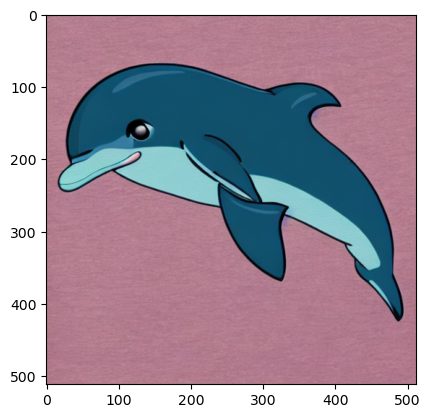

In [3]:
image = run(model, prompt="dolphin baby", seed=40)
plt.imshow(image)

In [4]:
#LAYER PATHS IN THE RIGHT ORDER

my_self_layers =[
    '.unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1', #1
    '.unet.down_blocks.0.attentions.1.transformer_blocks.0.attn1', #2
    '.unet.down_blocks.1.attentions.0.transformer_blocks.0.attn1', #3
    '.unet.down_blocks.1.attentions.1.transformer_blocks.0.attn1', #4
    '.unet.down_blocks.2.attentions.0.transformer_blocks.0.attn1', #5
    '.unet.down_blocks.2.attentions.1.transformer_blocks.0.attn1', #6
    '.unet.mid_block.attentions.0.transformer_blocks.0.attn1', #7
    '.unet.up_blocks.1.attentions.0.transformer_blocks.0.attn1', #8
    '.unet.up_blocks.1.attentions.1.transformer_blocks.0.attn1', #9
    '.unet.up_blocks.1.attentions.2.transformer_blocks.0.attn1', #10
    '.unet.up_blocks.2.attentions.0.transformer_blocks.0.attn1', #11
    '.unet.up_blocks.2.attentions.1.transformer_blocks.0.attn1', #12
    '.unet.up_blocks.2.attentions.2.transformer_blocks.0.attn1', #13
    '.unet.up_blocks.3.attentions.0.transformer_blocks.0.attn1', #14
    '.unet.up_blocks.3.attentions.1.transformer_blocks.0.attn1', #15
    '.unet.up_blocks.3.attentions.2.transformer_blocks.0.attn1' #16
]

my_cross_layers =[
    '.unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2',
    '.unet.down_blocks.0.attentions.1.transformer_blocks.0.attn2',
    '.unet.down_blocks.1.attentions.0.transformer_blocks.0.attn2',
    '.unet.down_blocks.1.attentions.1.transformer_blocks.0.attn2',
    '.unet.down_blocks.2.attentions.0.transformer_blocks.0.attn2',
    '.unet.down_blocks.2.attentions.1.transformer_blocks.0.attn2',
    '.unet.mid_block.attentions.0.transformer_blocks.0.attn2',
    '.unet.up_blocks.1.attentions.0.transformer_blocks.0.attn2',
    '.unet.up_blocks.1.attentions.1.transformer_blocks.0.attn2',
    '.unet.up_blocks.1.attentions.2.transformer_blocks.0.attn2',
    '.unet.up_blocks.2.attentions.0.transformer_blocks.0.attn2',
    '.unet.up_blocks.2.attentions.1.transformer_blocks.0.attn2',
    '.unet.up_blocks.2.attentions.2.transformer_blocks.0.attn2',
    '.unet.up_blocks.3.attentions.0.transformer_blocks.0.attn2',
    '.unet.up_blocks.3.attentions.1.transformer_blocks.0.attn2',
    '.unet.up_blocks.3.attentions.2.transformer_blocks.0.attn2'
]

In [6]:
#BLOCKS:
down_1 = [0,1]
down_2 = [2,3]
down_3 = [4,5]
mid = [6]
up_1 = [7,8,9]
up_2 = [10,11,12]
up_3 = [13,14,15]

PLOT IMAGE

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  8.79it/s]


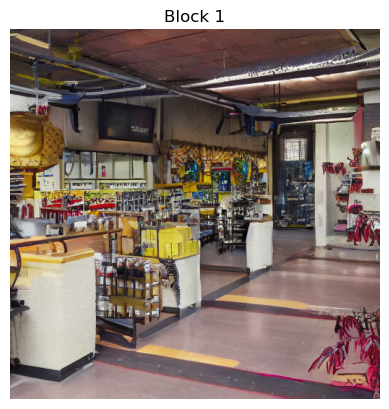

In [8]:
envoys = model._envoy.modules(lambda envoy : envoy._module_path.endswith('attn2'))# and envoy._module_path not in [my_cross_layers[idx] for idx in [np.concatenate[down_3, mid]]])

#intervention1 = AblationIntervention(envoys)

blank_embeds = encode_prompt("", model)
intervention2 = EncoderIntervention(blank_embeds, envoys)
    
image = run(model, prompt="blue elephant", seed=40, interventions=[intervention2])

plt.title("Block 1")
plt.axis('off')
plt.imshow(image)

<span style="color: #FF4FA7; font-family: Times New Roman; font-size: 2em;">Accessing Attention Maps</span>

In [21]:
#generator.manual_seed(40)
with model.generate('purple woodpecker', num_inference_steps=50, validate=False, scan=False): #
        
    modules = model._envoy.envoys(lambda envoy : envoy._module_path.endswith('attn1') or envoy._module_path.endswith('attn2')) #for all self and cross attn right now

    i = 0
#with model.generate("blue cat", scan=False, validate=False):
    for i in range(50):
        if i != 0:
            module.next()
        attn = model.unet.mid_block.attentions[0].transformer_blocks[0].attn1
        #or: .unet.up_blocks.2.attentions.1.transformer_blocks.0.attn1
        q = attn.to_q.output.save()
        k = attn.to_k.output.save()

        attn_map = attn.input[1]["attention_mask"].save()
        encoder = attn.input[1]["encoder_hidden_states"].save()

    q = attn.head_to_batch_dim(q.value)
    k = attn.head_to_batch_dim(k.value)

    probs = attn.get_attention_scores(q, k)
    print(probs.shape)
        
        #probs_np = probs.cpu().numpy()



# for i in range(50): #timesteps  
#     if i != 0:
#         module.next() #this is how you tell the module that we are working with the next iteration
        
#     module.output[:] = 0 #ablates output
# shapes.append((module._module_path, module.output.shape.save()))



# plt.figure(figsize=(20, 20))
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(probs_np[i], cmap='cool')#, interpolation='nearest')
#    # plt.colorbar()
# plt.title
# plt.show()

AttributeError: 'Diffuser' object has no attribute 'envoys'

ATTENTION MAPS

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


None
torch.Size([16, 64, 64])


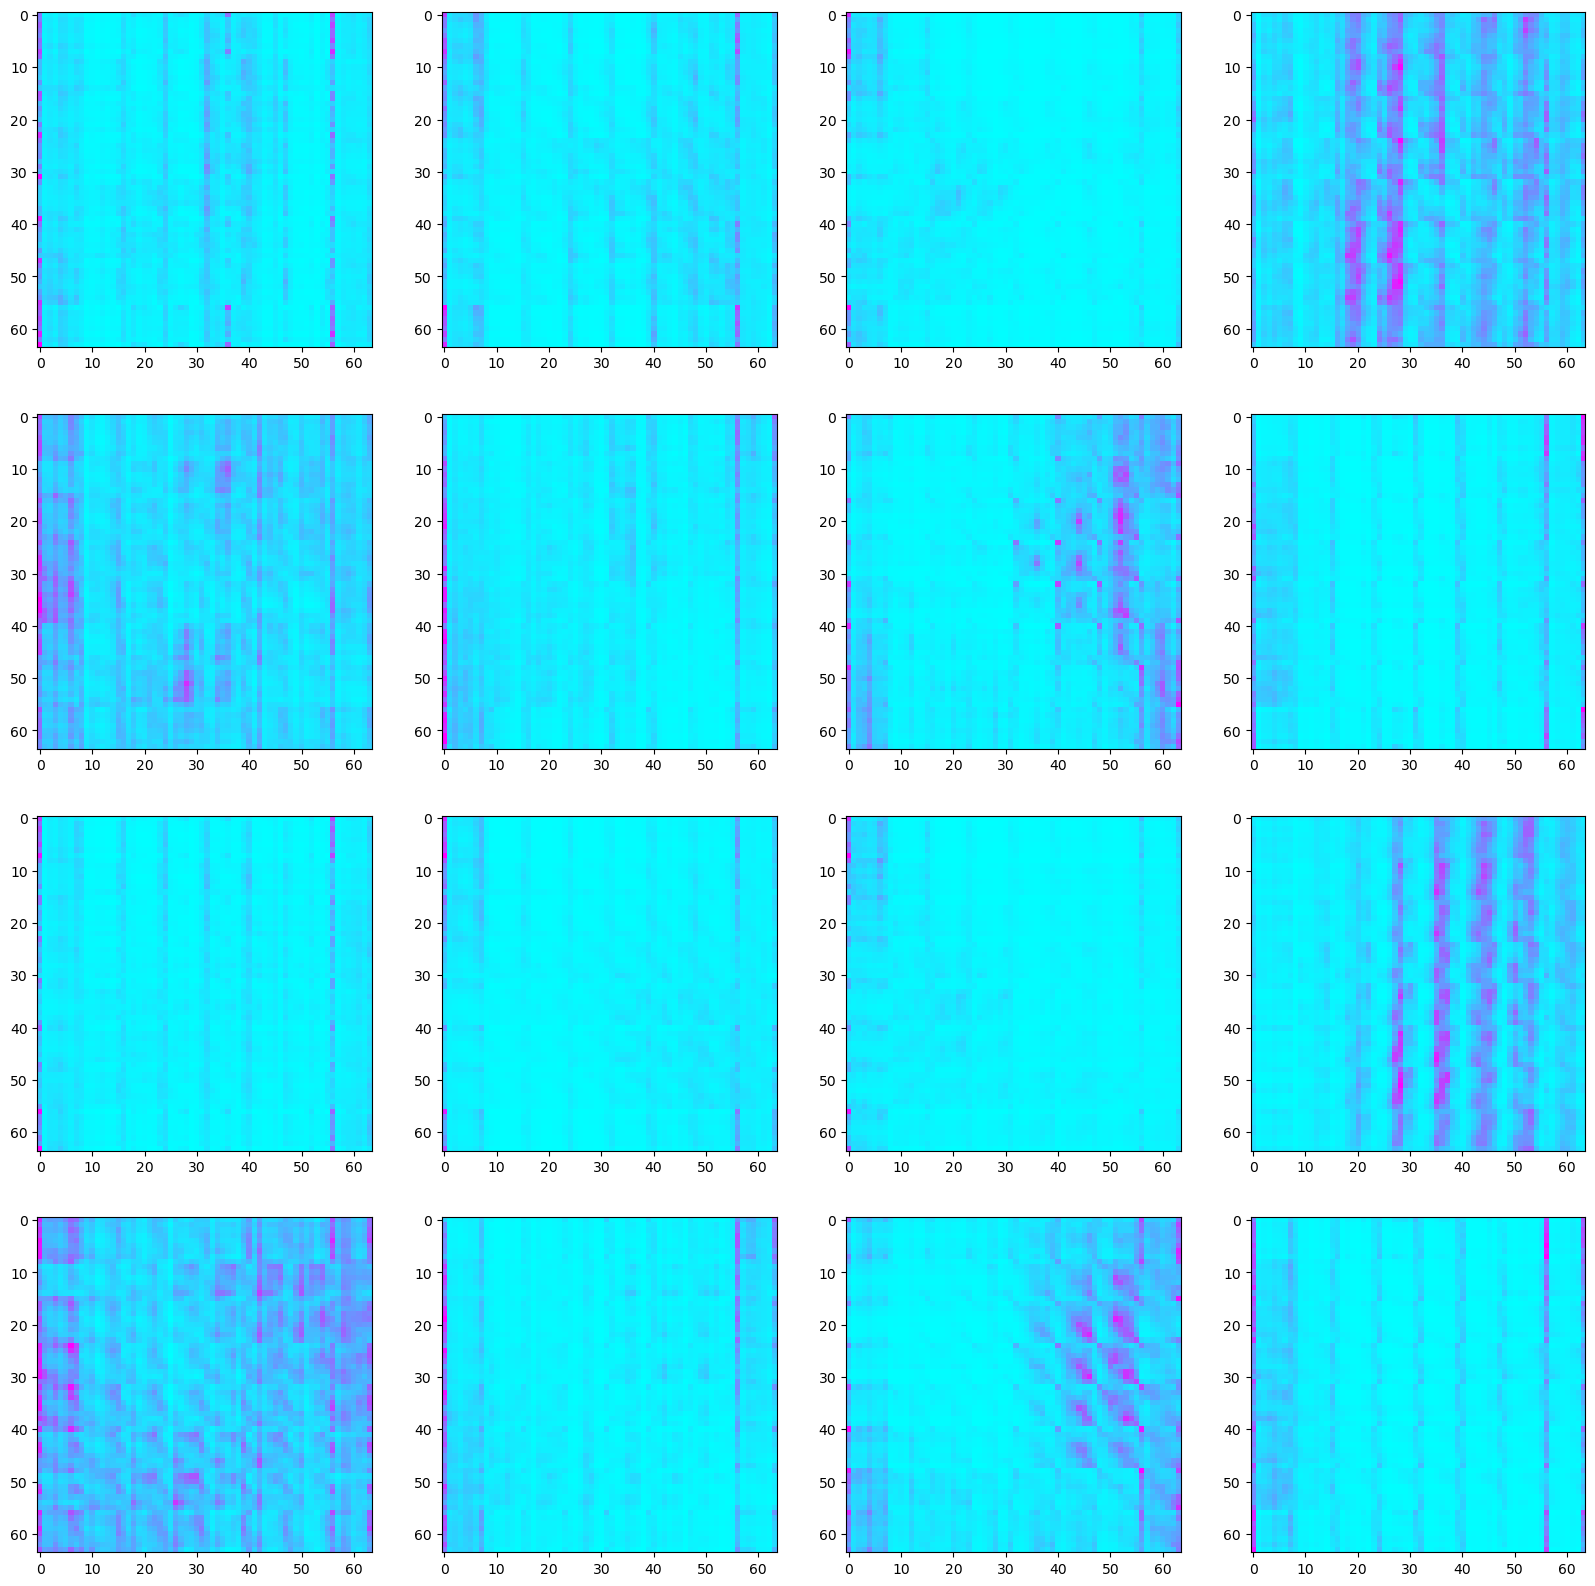

In [20]:
# from nnsight.models.DiffusionModel import DiffusionModel

# model = DiffusionModel("CompVis/stable-diffusion-v1-4", dispatch=True).to('cuda:0')
# generator = torch.Generator()

with model.generate("blue cat", scan=False, validate=False):
    attn = model.unet.mid_block.attentions[0].transformer_blocks[0].attn1
    #.unet.up_blocks.2.attentions.1.transformer_blocks.0.attn1
    q = attn.to_q.output.save()
    k = attn.to_k.output.save()

    attn_map = attn.input[1]["attention_mask"].save()
    encoder = attn.input[1]["encoder_hidden_states"].save()

print(attn_map)
q = attn.head_to_batch_dim(q.value)
k = attn.head_to_batch_dim(k.value)

probs = attn.get_attention_scores(q, k)
print(probs.shape)
probs_np = probs.cpu().numpy()

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(probs_np[i], cmap='cool')#, interpolation='nearest')
   # plt.colorbar()
plt.title
plt.show()